In [89]:
import pandas as pd
raw = pd.read_csv('data/1003.csv')
raw.timestamp = pd.to_datetime(raw.timestamp)
raw.set_index('timestamp', inplace=True)
raw.head()

,room_id,co2,temperature,humidity
timestamp,,,,
2022-11-16 15:30:02+00:00,37239,1371,19.6,48
2022-11-16 15:32:02+00:00,37239,1367,19.6,48
2022-11-16 15:34:02+00:00,37239,1390,19.6,48
2022-11-16 15:36:02+00:00,37239,1384,19.6,48
2022-11-16 15:38:02+00:00,37239,1377,19.6,48


In [90]:
df = raw.copy().between_time('07:30', '16:30')
df = df[~df.index.dayofweek.isin([5, 6])]
df['date'] = df.index.date
df['time'] = df.index.time

df = df[df['co2'] < 5000]
# df = df[df['co2'] > 600]
df = df[df['temperature'].notna()]
df.head()

,room_id,co2,temperature,humidity,date,time
timestamp,,,,,,
2022-11-16 15:30:02+00:00,37239,1371,19.6,48,2022-11-16,15:30:02
2022-11-16 15:32:02+00:00,37239,1367,19.6,48,2022-11-16,15:32:02
2022-11-16 15:34:02+00:00,37239,1390,19.6,48,2022-11-16,15:34:02
2022-11-16 15:36:02+00:00,37239,1384,19.6,48,2022-11-16,15:36:02
2022-11-16 15:38:02+00:00,37239,1377,19.6,48,2022-11-16,15:38:02


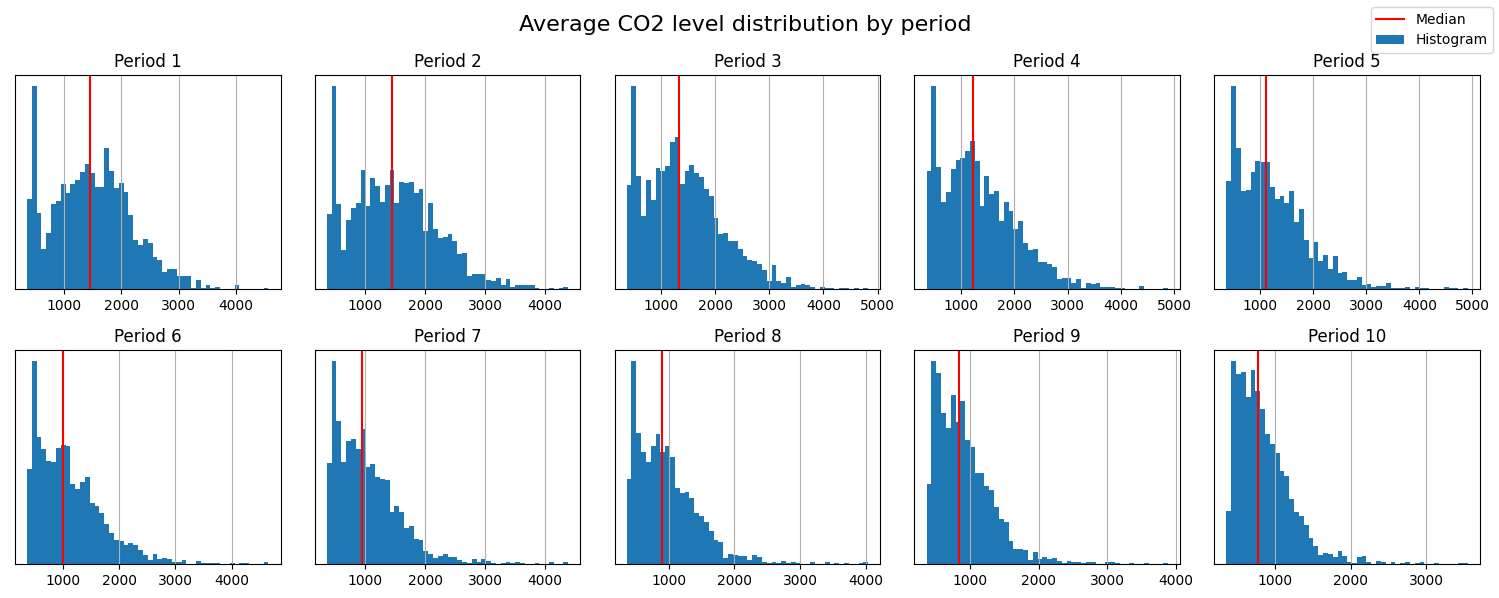

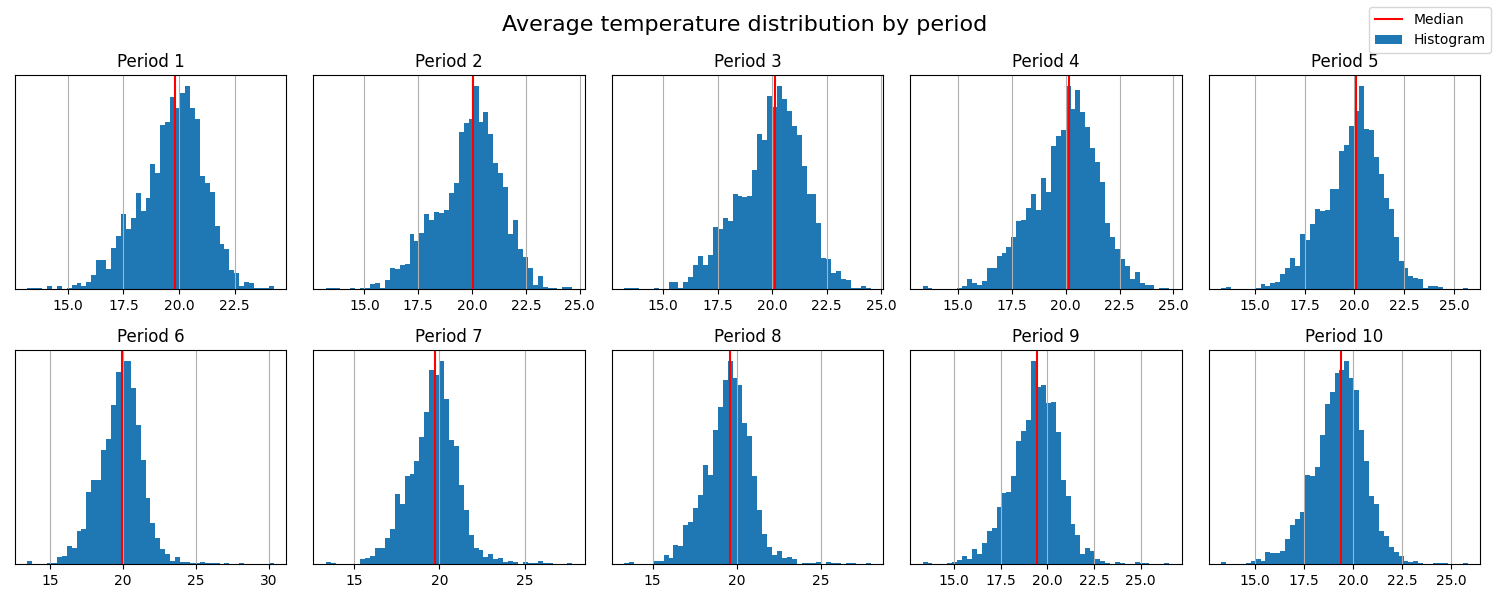

In [91]:
import matplotlib.pyplot as plt

df['minutes'] = df.index.hour * 60 + df.index.minute - (7 * 60 + 30)

def get_lesson_time(time):
    lesson = time / 50
    if lesson % 1 > 0.8:
        return -1
    return  lesson // 1

df['lesson'] = df.minutes.apply(get_lesson_time)
df = df[df['lesson'] != -1]
df.drop(columns=['minutes'], inplace=True)

lesson_df = df.groupby(['room_id', 'date', 'lesson']).mean(numeric_only=True).reset_index()
lesson_df.head()

lesson_df.date = pd.to_datetime(lesson_df.date)
lesson_df['weekday'] = lesson_df.date.dt.dayofweek

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f"Period {i+1}")
    lesson_df[lesson_df['lesson'] == i+1].co2.hist(ax=ax, bins=50)
    ax.axvline(lesson_df[lesson_df['lesson'] == i+1].co2.median(), color='red')
    ax.get_yaxis().set_visible(False)

fig.legend(['Median', 'Histogram'], loc='upper right')
plt.suptitle('Average CO2 level distribution by period', fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f"Period {i+1}")
    lesson_df[lesson_df['lesson'] == i+1].temperature.hist(ax=ax, bins=50)
    ax.axvline(lesson_df[lesson_df['lesson'] == i+1].temperature.median(), color='red')
    ax.get_yaxis().set_visible(False)

fig.legend(['Median', 'Histogram'], loc='upper right')
plt.suptitle('Average temperature distribution by period', fontsize=16)
plt.tight_layout()
plt.show()

In [92]:
lesson_df['z_temp'] = lesson_df.groupby(['room_id', 'date'])['temperature'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df['z_hum'] = lesson_df.groupby(['room_id', 'date'])['humidity'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df['z_co2'] = lesson_df.groupby(['room_id', 'date'])['co2'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df.head()

,room_id,date,lesson,co2,temperature,humidity,weekday,z_temp,z_hum,z_co2
0,37226,2022-09-07,9.0,613.000000,21.200000,49.000000,2,0.707107,0.707107,0.707107
1,37226,2022-09-07,10.0,596.750000,21.175000,48.850000,2,-0.707107,-0.707107,-0.707107
2,37226,2022-09-08,0.0,930.476190,21.323810,44.857143,3,-1.090332,2.198109,1.398941
3,37226,2022-09-08,1.0,921.000000,21.509524,43.714286,3,-0.367711,1.613099,1.328066
4,37226,2022-09-08,2.0,632.047619,21.504762,40.571429,3,-0.386240,0.004321,-0.833074


In [118]:
rooms_df = pd.read_csv("data/rooms.csv")

def to_int(st):
    st = "".join(filter(str.isdigit, st))
    if st:
        return int(st)
    return None

rooms_df.name = rooms_df.name.apply(to_int)
rooms_dict = rooms_df[rooms_df['building_id'] == 1003].set_index('name').id.to_dict()
schedule_df = pd.read_csv("pirmdiena.csv")
schedule_df['room_id'] = schedule_df.room.apply(lambda x: rooms_dict.get(x, None))
schedule_df = schedule_df[schedule_df['room_id'].notna()]

schedule_df['class'] = '12sb'
# schedule_df.to_csv('pirmdiena.csv', index=False)
print(schedule_df.head())

   weekday  lesson        name   room  room_id class
0        1       1   Bioloģija  110.0    37244  12sb
1        1       1      Ķīmija  212.0    37254  12sb
2        1       2   Bioloģija  110.0    37244  12sb
3        1       2      Ķīmija  212.0    37254  12sb
4        1       4  Matemātika  132.0    37259  12sb


In [119]:
lesson_co2_data = pd.merge(lesson_df, schedule_df, on=['room_id', 'weekday', 'lesson'], how='inner')
lesson_co2_data.head()

,room_id,date,lesson,co2,temperature,humidity,weekday,z_temp,z_hum,z_co2,name,room,class
0,37226,2022-09-13,4.0,646.809524,19.471429,49.761905,1,-1.067444,-1.009520,-1.466946,Latviešu val.,204.0,12sb
1,37226,2022-09-20,4.0,1057.952381,20.685714,58.238095,1,1.097948,0.511455,1.280638,Latviešu val.,204.0,12sb
2,37226,2022-09-27,4.0,720.904762,20.438095,52.571429,1,0.792143,-0.408379,-0.008686,Latviešu val.,204.0,12sb
3,37226,2022-10-04,4.0,557.809524,18.966667,50.380952,1,-0.618755,-1.181956,-1.926948,Latviešu val.,204.0,12sb
4,37226,2022-10-11,4.0,721.714286,20.171429,50.809524,1,0.742827,1.270299,0.354461,Latviešu val.,204.0,12sb


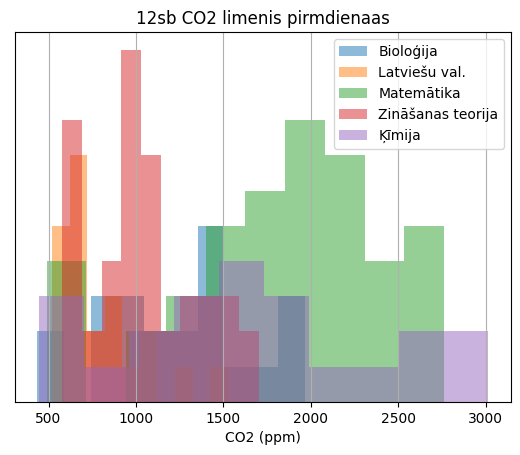

In [133]:
lesson_co2_data.groupby("name").co2.hist(bins=10, alpha=0.5, legend=True)
plt.title("12sb CO2 limenis pirmdienaas")
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlabel("CO2 (ppm)")
plt.show()